In [6]:
#Doğa Durmaz
#Ecenaz Güngör

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the input images
image1 = cv2.imread(r"hill_left.JPG")
image2 = cv2.imread(r"hill_right.JPG")

In [3]:
# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

In [4]:
rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# Detect keypoints and compute descriptors for gray 1
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)

# Detect keypoints and compute descriptors for gray 2
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)
# Extract matching points from good matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# Estimate affine geometric transform
M, _ = cv2.estimateAffine2D(src_pts, dst_pts)
output_size = (rgb1.shape[1] + rgb2.shape[1], max(rgb1.shape[0], rgb2.shape[0]))
transformed_img = cv2.warpAffine(rgb2, M, output_size, flags=cv2.WARP_INVERSE_MAP)
mask = np.ones_like(rgb2)
mask = cv2.rectangle(mask, (0, 0), (transformed_img.shape[1], transformed_img.shape[0]), (255, 255, 255), -1)
# Transform the second image
transformed_mask = cv2.warpAffine(mask, M, output_size, flags=cv2.WARP_INVERSE_MAP)
# Set the remaining areas in the transformed mask to black
result_height, result_width = transformed_img.shape[:2]
# Create the corresponding mask for the extended image
extended_mask = np.zeros((result_height, result_width))
original_height, original_width = image1.shape[:2]
paddingRight = result_width - original_width
paddingTop = result_height - original_height
# Extend the first image by padding it with zeros
extended_image1 = np.pad(rgb1, ((0, paddingTop), (0, paddingRight), (0, 0)))
extended_mask[0:original_height, 0:original_width] = 255
result = np.copy(extended_image1)  
# Iterate over each pixel of the transformed image
# Calculate the average value by taking the mean of corresponding pixels from both images
for y in range(result_height):
    for x in range(int(result_width/2)):
        if np.any(transformed_mask[y, x] > 0):  
            result[y, x] = np.mean([result[y, x], transformed_img[y, x]], axis=0)
for y in range(result_height):
    for x in range(int(result_width/2), result_width):
        if np.any(transformed_mask[y, x] > 0):  
            result[y, x] = transformed_img[y, x]
# Create an empty image for the combined result
combined_image = np.zeros_like(extended_image1)
# Get the size of the overlapping region
overlap_width = transformed_img.shape[1] - extended_image1.shape[1]
# Iterate over each pixel coordinate within the overlapping region
for y in range(extended_image1.shape[0]):
    for x in range(extended_image1.shape[1]):
        # Calculate the weight for the extended image and the transformed image
        weight_1 = 1.0 - (x / extended_image1.shape[1])  # Weight for extended_image1
        weight_2 = 1.0 - weight_1  # Weight for transformed_image
        
        # Calculate the combined pixel value by taking the weighted average
        combined_pixel = (extended_image1[y, x] * weight_1) + (transformed_img[y, x + overlap_width] * weight_2)
        
        # Assign the combined pixel value to the corresponding pixel in the combined image
        combined_image[y, x] = np.uint8(combined_pixel)



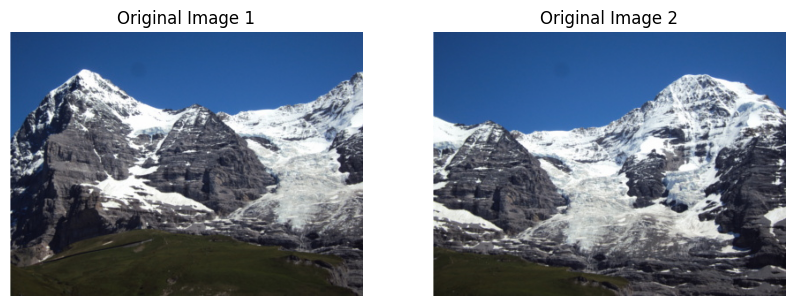

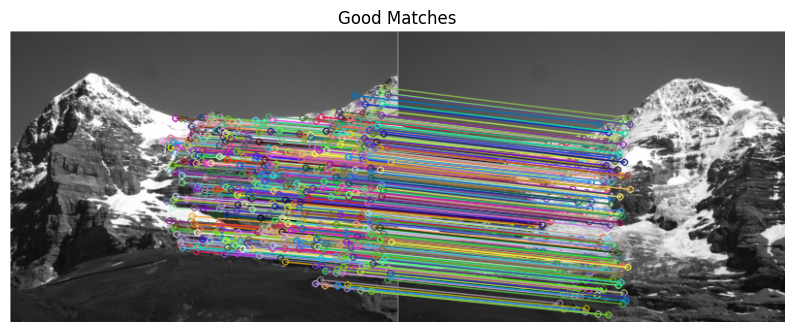

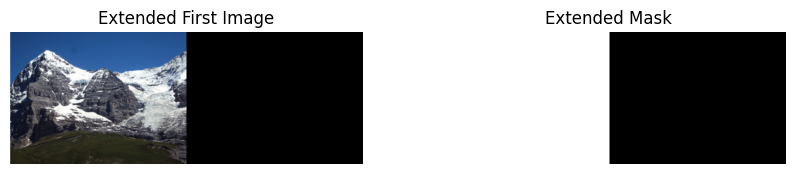

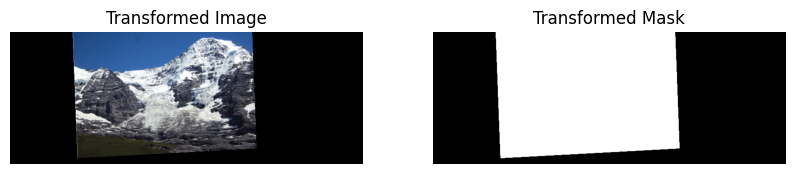

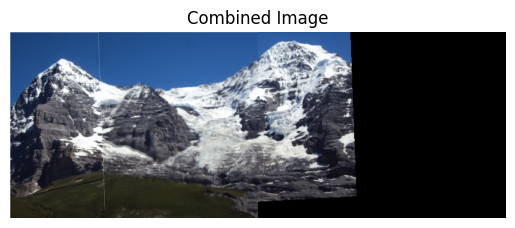

In [5]:

# Display the original images
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image 1')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Original Image 2')
axs[1].axis('off')
plt.show()
# Display the good matches
output_matches = cv2.drawMatches(gray1, keypoints1, gray2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_matches, cv2.COLOR_BGR2RGB))
plt.title('Good Matches')
plt.axis('off')
plt.show()
# Display the extended first image and its corresponding mask
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(extended_image1)
axs[0].set_title('Extended First Image')
axs[0].axis('off')
axs[1].imshow(extended_mask, cmap='gray')
axs[1].set_title('Extended Mask')
axs[1].axis('off')
plt.show()
# Display the transformed image and its mask
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(transformed_img)
axs[0].set_title('Transformed Image')
axs[0].axis('off')

axs[1].imshow(transformed_mask, cmap='gray')
axs[1].set_title('Transformed Mask')
axs[1].axis('off')
plt.show()
# Visualize the combination result
plt.imshow(result)
plt.title('Combined Image')
plt.axis('off')
plt.show()